Enter the Cloudinary API key: ········
Enter the Cloudinary API Secret: ········
Aquiring data for risk grids
Data acquired, creating grids
NOPS grid done
SOPS grid done
Uploading to Cloudinary
Upload complete. Starting on fire guard map
Requesting spatial data from rest services
Please enter CAL FIRE agol username. Case sensitive. Must end with '.CALFIRE': ewalmsley.CALFIRE
Enter password: ········
Data recieved, generating maps
FireGuard map complete. Uploading to cloudinary
Upload complete. Requesting discussion text
Discussion text acquired. Parsing text
Discussion text parsed.
# Bullets in NOPS forecast: 6
# Bullets in SOPS forecast: 4
Adding 2 bullet point(s) from SOPS weather to SOPS discussion for visual balance
Done with discussion text. Parsing Technosylva statewide risk forecast to get highest risk time of each day in the next 72hrs
Highest risk times acquired, converting to milliseconds in UTC to query Technosylva rest service.
Highest risk times converted, requesting raste

'https://res.cloudinary.com/wftiiccdn/image/upload/v1669144365/wftiic_media/wftiic_weekly_20221122.pdf'

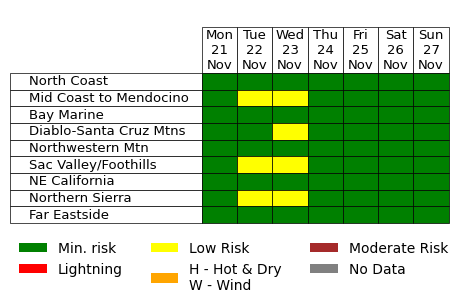

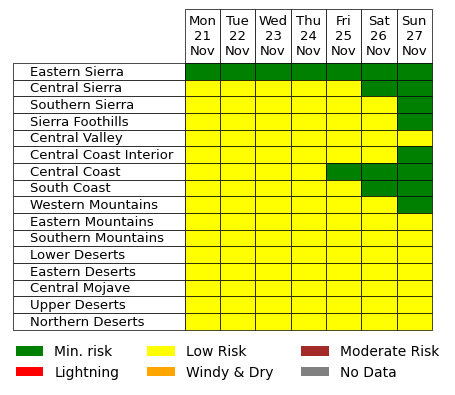

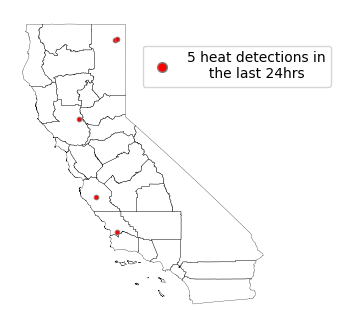

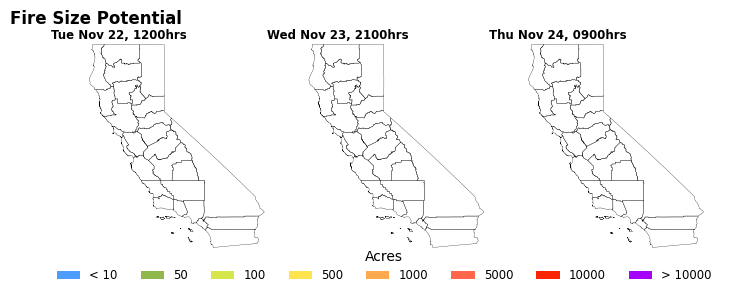

In [1]:
#The purpose of this script is to automate the WFTIIC's daily product
#The script requires the following information to function, and will request it from the user
# 1. Cloudinary API key
# 2. Cloudinary API Secret
# 3. CAL FIRE ArcGIS Online username and password
# 4. Password for the CALFIRE_Viewer account from technosylva

#Import dependencies
import requests
from datetime import datetime
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import io
import getpass

# initiate cloudinary modules
import cloudinary #general libary
from cloudinary import uploader #for uploading hehe
import cloudinary.api #for getting asset information

Cldnry_api_key = getpass.getpass(prompt="Enter the Cloudinary API key: ")
Cldnry_api_secret = getpass.getpass(prompt="Enter the Cloudinary API Secret: ")

#setup authorization stuff
cloudinary.config( 
  cloud_name = "wftiiccdn", 
  api_key = Cldnry_api_key, #change to getpass
  api_secret = Cldnry_api_secret #change to getpass
)

#output message
print("Aquiring data for risk grids")

start = datetime.now()
#empty dict to store data
ps_fcst = {}

#today
url0 = "https://fsapps.nwcg.gov/psp/arcgis/rest/services/npsg/outlooks_forecast/MapServer/0/query?where=gacc IN ('California North Ops','California South Ops')&f=json&returnGeometry=false&outFields=drynesscode,symbol,timestampdate,type,nat_code"
#tomorrow
url1 = "https://fsapps.nwcg.gov/psp/arcgis/rest/services/npsg/outlooks_forecast/MapServer/1/query?where=gacc_name IN ('California North Ops','California South Ops')&f=json&returnGeometry=false&outFields=drynesscode,symbol,timestampdate,type,nat_code"
#subsequent days
url2 = "https://fsapps.nwcg.gov/psp/arcgis/rest/services/npsg/outlooks_forecast/MapServer/2/query?where=gacc_name IN ('California North Ops','California South Ops')&f=json&returnGeometry=false&outFields=drynesscode,symbol,timestampdate,type,nat_code"
url3 = "https://fsapps.nwcg.gov/psp/arcgis/rest/services/npsg/outlooks_forecast/MapServer/3/query?where=gacc_name IN ('California North Ops','California South Ops')&f=json&returnGeometry=false&outFields=drynesscode,symbol,timestampdate,type,nat_code"
url4 = "https://fsapps.nwcg.gov/psp/arcgis/rest/services/npsg/outlooks_forecast/MapServer/4/query?where=gacc_name IN ('California North Ops','California South Ops')&f=json&returnGeometry=false&outFields=drynesscode,symbol,timestampdate,type,nat_code"
url5 = "https://fsapps.nwcg.gov/psp/arcgis/rest/services/npsg/outlooks_forecast/MapServer/5/query?where=gacc_name IN ('California North Ops','California South Ops')&f=json&returnGeometry=false&outFields=drynesscode,symbol,timestampdate,type,nat_code"
url6 = "https://fsapps.nwcg.gov/psp/arcgis/rest/services/npsg/outlooks_forecast/MapServer/6/query?where=gacc_name IN ('California North Ops','California South Ops')&f=json&returnGeometry=false&outFields=drynesscode,symbol,timestampdate,type,nat_code"

urls_list = [url0, url1, url2, url3, url4, url5, url6]

#initialize empty lists and count vars
day_of_fcst = 0
#empty lists for table data
table_data = []
#empty list for column names
col_list = []
#empty list for index names
index_list = []
#empty lists for colors of each table
nops_colors = []
nops_cellText = []
sops_colors = []
sops_cellText = []

#Fore each url in the list above
for i in urls_list:
    #initialize variables that change for each url
    #unsorted attributes (need to sort by name so they show up in a meaninful way)
    us_attr = []
    #table data lists of lists
    tdls = []
    
    ###Get data from the rest endpoint
    r = requests.request('GET', i)
    #read as json
    rspns_json = r.json()
    #store json response in the dictionary
    ps_fcst[day_of_fcst] = rspns_json
    
    #for each feature of the current url
    for j in ps_fcst[day_of_fcst]['features']:
        #store timestampdate in a variable
        esriTime = j['attributes']['timestampdate']
        #convert the timestamp date into datetime format
        better_time = datetime.fromtimestamp(esriTime/1000)
        #add one day because of the strucutre
        #better_time = better_time + timedelta(days=1) ### Removed 11/18 for deployment to binder.
        #reassign the timestamp date to the one that makes sense
        j['attributes']['timestampdate'] = better_time
    
    #create column list
    for k in ps_fcst[day_of_fcst]['features']:
        col_val = k['attributes']['timestampdate'] #grab timestamp date
        col_val = col_val.strftime('%a\n%d\n%b') #format for table
        col_list.append(col_val) #append to col list
        break #break allows appending only one date per layer
            
    #for each feature in the current url
    for l in ps_fcst[day_of_fcst]['features']:
        #append attribute data to unsorted attribute list
        us_attr.append(l['attributes'])
    #sort them by the 'nat_code' attribute (predictive services area)
    srtd_attr = sorted(us_attr, key=lambda d: d['nat_code'])
    #reassign features to be this new list
    ps_fcst[day_of_fcst]['features'] = srtd_attr  ### Recall, 'attributes' key no longer available
    
    for m in ps_fcst[day_of_fcst]['features']:
        #if type or symbol (used for denoting critical) do not equal none
        if m['type'] != None or m['symbol'] != None:
            #append dryness code plus type and symbol to the list
            tdls.append(str(m['drynesscode'])+str(m['type'])+str(m['symbol']))
            #get colors for cell table colors
        else:
            tdls.append(str(m['drynesscode'])+str(m['type'])+str(m['symbol']))
    #take above caputed data and append to table data
    table_data.append(tdls)
    
    if day_of_fcst == 6:
        for n in srtd_attr:
            index_list.append(n['nat_code'])
    
    #increment day of forecast by one
    day_of_fcst += 1

#ouput message
print("Data acquired, creating grids")
    
#Creating Tables

#create dataframe from table_data from api call
df = pd.DataFrame(table_data)

#Transpose so that psas are on the left side, date on top
df = df.T

#Specify that column and row (index) labels from lists created earlier
df.columns = col_list
df.index = index_list

#Create dictionary of descriptive PSA codes
psa_dscr = {
    'NC01':'North Coast',
    'NC02':'Mid Coast to Mendocino',
    'NC03A':'Bay Marine',
    'NC03B':'Diablo-Santa Cruz Mtns',
    'NC04':'Northwestern Mtn',
    'NC05':'Sac Valley/Foothills',
    'NC06':'NE California',
    'NC07':'Northern Sierra',
    'NC08':'Far Eastside',
    'SC01':'Eastern Sierra',
    'SC02':'Central Sierra',
    'SC03':'Southern Sierra',
    'SC04':'Sierra Foothills',
    'SC05':'Central Valley',
    'SC06':'Central Coast Interior',
    'SC07':'Central Coast',
    'SC08':'South Coast',
    'SC09':'Western Mountains',
    'SC10':'Eastern Mountains',
    'SC11':'Southern Mountains',
    'SC12':'Lower Deserts',
    'SC13':'Eastern Deserts',
    'SC14':'Central Mojave',
    'SC15':'Upper Deserts',
    'SC16':'Northern Deserts'
}

#create dfs for each gacc
nops_7day = df[df.index.str.contains('NC')]
sops_7day = df[df.index.str.contains('SC')]

#create row (index) label lists for each of the two gaccs
nops_index = []
sops_index =[]

#for each index in the index list
for i in index_list:
    # if NC is in the iterator
    if 'NC' in i:
        #get descriptive name, rather than code, from dictionary above
        nops_index.append(psa_dscr[i])
    else:
        #otherwise put it in the southops index list
        sops_index.append(psa_dscr[i])

#create fx to assign table cell colors
def assign_table_colors(df) -> list:
    colors = []
    for val in df.values:
        sub_colors = []
        for value in list(val):
            if '3None' in value:
                sub_colors.append('brown')
            elif '2None' in value:
                sub_colors.append('yellow')
            elif '1None' in value:
                sub_colors.append('green')
            elif 'IGNITIONL' in value: ############################### <- need to correct this one
                sub_colors.append('red')
            elif 'H' in value or 'W' in value:
                sub_colors.append('orange')
            elif '0None' in value:
                sub_colors.append('grey')
            else:
                sub_colors.append('grey')
        colors.append(sub_colors)
    return colors

#Function that examines the text in each cell and assigns the appropriate letter for the table
def assign_cell_text(df) -> list:
    cellText = []
    for val in df.values:
        subText = []
        for value in list(val):
            # if '3None' in value or '2None' in value or '1None' in value or '0None':
            #     subText.append('')
            # NOTE to self: Had to chage this from if elif elif elif, to if elif elif else to get the W text to show up in the table
            if 'IGNITIONL' in value:
                subText.append('L') 
            elif 'CRITICALH' in value:
                subText.append('H')
            elif 'CRITICALW' in value:
                subText.append('W')
            else: #'3None' in value or '2None' in value or '1None' in value or '0None':
                subText.append('')
        cellText.append(subText)
    return cellText

#create table colors lists of lists using fx
nops_colors = assign_table_colors(nops_7day); nops_cellText = assign_cell_text(nops_7day)
sops_colors = assign_table_colors(sops_7day); sops_cellText = assign_cell_text(sops_7day)
    
#create table figures
fig, ax = plt.subplots(figsize=(3.5,3))#width, height
ax.axis('off')

#Create the table
nops_table = ax.table(
    cellText = nops_cellText,
    cellLoc='center', #need to deal with cell text
    colLabels = nops_7day.columns,
    colWidths = [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
    rowLabels = nops_index,
    loc = 'center', 
    cellColours = nops_colors
)

#adjust height of only col headers
cellDict=nops_table.get_celld()
for i in range(len(col_list)):
    cellDict[(0,i)].set_height(0.2)

######################################################## NOTE Consider removing cause this doesn't appear to be doing anything
#adjust width of row labels only
for i in range(1,len(nops_index)):
    cellDict[(i,-1)].set_text_props(horizontalalignment='left')

#adjust
for key, cell in cellDict.items():
    #all cells, line with to 0.5
    cell.set_linewidth(0.5)

#turn of auto font sizing
nops_table.auto_set_font_size(False)
#specify specific fontsize
nops_table.set_fontsize(9.5)

from matplotlib.patches import Patch ######################### NOTE probably need to move this to the top when importing dependencies

#Create 'patches' or squares that'll be used for the legend
legend_patches = [
    Patch(facecolor='green'),
    Patch(facecolor='red'),
    Patch(facecolor='yellow'),
    Patch(facecolor='orange'),
    Patch(facecolor='brown'),
    Patch(facecolor='grey'),
]

#Create the legend
nops_leg = ax.legend(
    legend_patches, 
    ['Min. risk', 'Lightning', 'Low Risk', 'H - Hot & Dry\nW - Wind', 'Moderate Risk', 'No Data'], #labels
    loc=(-0.65, -0.25), #location
    ncol = 3, #Num columns
    frameon = False, #Turn off legend frame
)

nopsGrid_bytes = io.BytesIO()

#save the figure
plt.savefig(nopsGrid_bytes, format='png', bbox_inches="tight")#, transparent=True)

#ouput message
print("NOPS grid done")

nopsGrid_bytes.seek(0)

#Clear the figure and axis for a the south ops plot
fig = None
ax = None

#create new figure, axis for plotting
fig, ax = plt.subplots(
    figsize=(3.5,3.5)#width, height
)

#Turn off plot axis
ax.axis('off')

#get rid of extra space around the edgies
ax.axis('tight')

#plot the southops dataframe
sops_table = ax.table(
    cellText = sops_cellText,
    cellLoc = 'center',
    colLabels = sops_7day.columns,
    colWidths = [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
    rowLabels = sops_index,
    loc = 'center', 
    cellColours = sops_colors
)

#Specify height of column label cells
cellDict=sops_table.get_celld()
for i in range(len(col_list)):
    cellDict[(0,i)].set_height(0.2)

#specify line width for all cells
for key, cell in cellDict.items():
    cell.set_linewidth(0.5)

#turn off automatic font sizing
sops_table.auto_set_font_size(False)

#specify fong size
sops_table.set_fontsize(9.5)

#Create legend 'patches' or squares for legend
legend_patches = [
    Patch(facecolor='green'),
    Patch(facecolor='red'),
    Patch(facecolor='yellow'),
    Patch(facecolor='orange'),
    Patch(facecolor='brown'),
    Patch(facecolor='grey'),
]

#add legend to plot
ax.legend(
    legend_patches, 
    ['Min. risk', 'Lightning', 'Low Risk', 'Windy & Dry', 'Moderate Risk', 'No Data'],#labels
    loc=(-0.6, -0.3),#location on plot
    ncol = 3, #num columns
    frameon = False, #turn off legend frame
)

sopsGrid_bytes = io.BytesIO()

#save figure
plt.savefig(sopsGrid_bytes, format='png', bbox_inches="tight")#, transparent=True)

#ouput message
print("SOPS grid done")

#not sure exactly what this part does, but someone on stack exchange says subsequent fxs will start reading from start
sopsGrid_bytes.seek(0)

#ouput message
print("Uploading to Cloudinary")

#Send both images to cloudinary
uploader.upload_image(sopsGrid_bytes, folder='wftiic_media', public_id="sopsGrid", overwrite=True)
uploader.upload_image(nopsGrid_bytes, folder='wftiic_media', public_id="nopsGrid", overwrite=True)

#store in an dictionary asset info for sops grid
sopsGridAssetInfo = cloudinary.api.resource("wftiic_media/sopsGrid")
#store url to be used when producing the PDF
sopsRiskGridImageUrl = sopsGridAssetInfo['secure_url']

#store in a dictionary asset info for nops grid
nopsGridAssetInfo = cloudinary.api.resource("wftiic_media/nopsGrid")
#store url to be used when producing the PDF
nopsRiskGridImageUrl = nopsGridAssetInfo['secure_url']

#ouput message
print("Upload complete. Starting on fire guard map")

#Plot Fire Guard points in last 24hrs
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
import json
import geopandas as gpd

#ouput message
print("Requesting spatial data from rest services")

#store url for units in a variable
url_units = "https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/arcgis/rest/services/cdfadmin19_1/FeatureServer/0/query?&where=1%3D1&f=geojson"

#old URL that takes forever to respond and often kicks back an error
# "https://egis.fire.ca.gov/arcgis/rest/services/FRAP/CalFireUnits/MapServer/0/query?outFields=*&where=1%3D1&f=geojson"
#https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/arcgis/rest/services/cdfadmin19_1/FeatureServer/0/query?&where=1%3D1&f=geojson

#hit rest service to get spatial data
rr = requests.request('GET', url_units)

#convert to json fo use as a dictionary
json_units = rr.json()

#convert to geodataframe for plotting
units = gpd.GeoDataFrame.from_features(json_units['features'])

#specify CRS
units.crs = 'epsg:4326'

#transform to california projection
units = units.to_crs(epsg=3857)

#credentials
usernm = input("Please enter CAL FIRE agol username. Case sensitive. Must end with \'.CALFIRE': ")
url = 'https://www.arcgis.com'
#create a logged in instance
gis = GIS(url=url, username=usernm) #, password=pw)

#fire guard points url, Item details can be found here: https://calfire-forestry.maps.arcgis.com/home/item.html?id=c12b7affcfe74cf4ac4c25902ee5862f
#url_fgPnts = "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/FireGuard3_PointView/FeatureServer/"

#get item from arcgis
item = gis.content.get("c12b7affcfe74cf4ac4c25902ee5862f")

#store the layer in an object
fgPnts = item.layers[0]

#have layers, but don't need all features need to filter by time
#create datetime object representing the current time
now = datetime.now()

#subtract 24 hours from current time
neg24hrs = now - timedelta(hours=24)

#create new variable that is current date - 24 hours in YYYY-MM-DD HH:MM:SS format
neg24hrs_t = neg24hrs.strftime('%Y-%m-%d %H:%M:%S')

#query the layer for n/sops and creation time greater than 24hrs ago
fgPnts_sdf = fgPnts.query(where="GACCOfIncident IN ('ONCC','OSCC') AND CreationDate >= TIMESTAMP '{t}'".format(t=neg24hrs_t)).sdf

#store the number of detections in a variable
NumFgPnts = len(fgPnts_sdf)

#ouput maps
print("Data recieved, generating maps")

fgMap24hrs_bytes = io.BytesIO()

#there are any fgPnts...
if NumFgPnts > 0:
    #store variable for use later
    noDetections = False
    
    #convert to a geodataframe so that it can be plotted with other data above
    fgPnts_gdf = gpd.GeoDataFrame(
        data=fgPnts_sdf,
        geometry=gpd.points_from_xy(fgPnts_sdf.LongWGS84_DD, fgPnts_sdf.LatWGS84_DD),
        crs = 'epsg:4326' #specify WGS84 since we're using lat long
    )

    #transform to california projection that uses meters
    fgPnts_gdf = fgPnts_gdf.to_crs(epsg=3857)

    #create a figure and axis for plotting
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))

    #plot the data
    units.plot(ax=ax, facecolor="none", edgecolor = 'black', linewidth = 0.2, aspect = 1)
    fgPnts_gdf.plot(ax=ax, color = 'red', markersize = 12, edgecolor='grey', linewidth = 0.6, aspect = 1)
    
    #turn off the x-y axis cause we don't need'em
    ax.axis('off')
    
    #import Line2D class for legend
    from matplotlib.lines import Line2D

    #modify object for legend text
    #neg24hrs = neg24hrs.strftime('%Y-%m-%d %H:%M')

    #determine if more than one detection for better grammar
    if NumFgPnts > 1:
        plural = 's'
    else:
        plural = ''

    #create a label for the legend
    legLab = "{n} heat detection{p} in\n     the last 24hrs".format(p=plural, n=str(NumFgPnts))

    #create legend items
    legend_elements = [
        Line2D([0],[0], marker='o', color='w',
        label= legLab,
        markerfacecolor='red', markeredgecolor='grey', markersize=7)
    ]

    #add legend to plot
    ax.legend(handles=legend_elements, loc=(0.5, 0.75)) #(-0.05, -0.1)

    #save the figure
    plt.savefig(fgMap24hrs_bytes, format='png', bbox_inches="tight", dpi=200, transparent=True)
    
    #output message
    print("FireGuard map complete. Uploading to cloudinary")

else:
    noDetections = True #used for formatting the map in the final product
    
        #create a figure and axis for plotting
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))

    #plot the data
    units.plot(ax=ax, facecolor="none", edgecolor = 'black', linewidth = 0.2, aspect = 1)

    #turn off the x-y axis cause we don't need'em
    ax.axis('off')

    #import Line2D class for legend
    from matplotlib.lines import Line2D

    #modify object for legend text
    #neg24hrs = neg24hrs.strftime('%Y-%m-%d %H:%M')

    #create a label for the legend
    legLab = "Heat detections"

    #create legend items
    legend_elements = [
        Line2D([0],[0], marker='o', color='w',
        label= legLab,
        markerfacecolor='red', markeredgecolor='grey', markersize=7)
    ]

    #add legend to plot
    ax.legend(handles=legend_elements, loc=(0.5, 0.75), frameon=True)

    #text for no detections stamp
    NoDetectionsText = '0 heat detections\nin the last 24 hours'

    ax.text(0.5, 0.5, NoDetectionsText,
            fontsize = 10,
            fontweight= 'bold',
            color='white',
            backgroundcolor='green',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

    #save the figure
    plt.savefig(fgMap24hrs_bytes, format='png', bbox_inches="tight", dpi=200, transparent=True)
    
    #output message
    print("FireGuard map complete. Uploading to cloudinary")

    
fgMap24hrs_bytes.seek(0)

#upload image to cloudinary
uploader.upload_image(fgMap24hrs_bytes, folder='wftiic_media', public_id="fgMap24hrs", overwrite=True)

#store in an dictionary asset info for sops grid
fgMap24hrsAssetInfo = cloudinary.api.resource("wftiic_media/fgMap24hrs")
#store url to be used when producing the PDF
fgMap24hrsImageUrl = fgMap24hrsAssetInfo['secure_url']

#output message
print("Upload complete. Requesting discussion text")

#This section does the following
# 1. acquires the latest forecast discussion for both regions
# 2. cleans the discussion of html tags and other things we don't want
# 3. compares the regional discussions and balances them with sops weather bullets
# 4. Uses technosylva's pdf to determine the statewide highest risk time and stores it for use later

#store URLs in variables
nops_discussion = "https://fsapps.nwcg.gov/psp/npsg/forecast/api/gaccs/4/latest-forecast"
sops_discussion = "https://fsapps.nwcg.gov/psp/npsg/forecast/api/gaccs/8/latest-forecast"

#initiate requests
r_nops = requests.request('GET', nops_discussion)
r_sops = requests.request('GET', sops_discussion)

#convert to json
r_nops = r_nops.json()
r_sops = r_sops.json()

#output message
print("Discussion text acquired. Parsing text")

#store content in object
nops_forecastFuels = r_nops['forecastFuels']
sops_forecastFuels = r_sops['forecastFuels']

#get weather content for sops to balance n/sops
sops_forecastWeather = r_sops['forecastWeather']

#split by newline character
nops_forecastFuels = nops_forecastFuels.split('\n')
sops_forecastFuels = sops_forecastFuels.split('\n')
sops_forecastWeather = sops_forecastWeather.split('\n')

#first take care of the forecast fuels data
#create list of lists
ff_list = [nops_forecastFuels, sops_forecastFuels, sops_forecastWeather]

import re  ### Import just specific fx and move to dependency import at beginning of script when finalizing
import html
import unicodedata

#for each of the forecast fuels list...
for i in range(len(ff_list)):
    #for each item in each of the lists...
    for j in range(len(ff_list[i])):
        #remove html tags
        html_tags = '<[^<]+?>'
        ff_list[i][j] = re.sub(html_tags, '', ff_list[i][j]) #reassign iterator by removing regex pattern
        
        #remove "Weather Discussion:" given that it doesn't really apply
        wx_dis = 'Weather Discussion:'
        ff_list[i][j] = re.sub(wx_dis, '', ff_list[i][j])
        
        #remove any preceeding dash marks
        dash = r"[-]+"
        ff_list[i][j] = re.sub(dash, '', ff_list[i][j], count=1) #count will only do it once per list item
        
        #remove annoying bullet points
        annoying_bullets = "&middot;"
        ff_list[i][j] = re.sub(annoying_bullets, '', ff_list[i][j])

        #remove annoying non-breaking space
        annoying_bullets = "&nbsp;"
        ff_list[i][j] = re.sub(annoying_bullets, '', ff_list[i][j])
        
        #remove html entities
        ff_list[i][j] = html.unescape(ff_list[i][j])

        #remove any unicode characters
        ff_list[i][j] = unicodedata.normalize('NFKD', ff_list[i][j])

        #remove bullet points and tabs
        #ff_list[i][j] = ff_list[i][j][1:]

        #remove preceeding and trailing spaces
        ff_list[i][j] = ff_list[i][j].strip()

        #now nops/sops_forecastFuels are lists of strings with no preceeding bullets

#Remove the repetetive drought link item in nops forecast fuels
#count = 0
for i in nops_forecastFuels:
    if 'https://droughtmonitor.unl' in i:
        nops_forecastFuels.remove(i)
    # else:
    #     count += 1

#store forecast resources 
nops_forecastResources = r_nops['forecastResources']

#create empty dictionary to store preparedness levels
pls = {
    'nops':'',
    'sops':'',
    'nat':''
}

#regex pattern to search through text for PLs
pl_regex = ['North Ops:(.*?)<', 'South Ops:(.*?)<', 'National:(.*?)<']

#import dependency
import itertools

#looping through two items at once to get preparedness level from api
for (i, k) in zip(pl_regex, pls.keys()):
    #search each item in forecasted resources for the data
    pl_search = re.search(str(i), nops_forecastResources) #only need NOPS cause all PLs are ther
    pls[k] = int(pl_search.group(1)) #append to dictionary

#output message
print("Discussion text parsed.")    

#combining sops fFuels and weather

#see how many bullet points nops has
print('# Bullets in NOPS forecast: ' + str(len(nops_forecastFuels)))

#see how many bullet points sops has
print('# Bullets in SOPS forecast: ' + str(len(sops_forecastFuels)))

#store difference in variable
discussionBulletsDifference = len(nops_forecastFuels)-len(sops_forecastFuels)

#compare the difference
print('Adding {} bullet point(s) from SOPS weather to SOPS discussion for visual balance'.format(str(discussionBulletsDifference)))

#create empty list
sops_FuelsWxCombined = []

#add forecast fuels to combined list
sops_FuelsWxCombined = sops_FuelsWxCombined + sops_forecastFuels

#for the lenght of the difference plus one (cause nops is ALWAYS wordier than sops)
for i in range(discussionBulletsDifference):

    #add items from the weather discussion
    sops_FuelsWxCombined.append(sops_forecastWeather[i])

#see what it looks like
#sops_FuelsWxCombined

#output message
print("Done with discussion text. Parsing Technosylva statewide risk forecast to get highest risk time of each day in the next 72hrs")

#This section gets the parses the text in the full extent risk potential report and stores the highest risk
#risk time of day for the next three days. The data is then converted and used to query the rest service to get
#the correct fire size potential image

#determine state wide highest risk times of day
stateRiskUrl = "https://calfirereport.wildfireanalyst.com/api/report/GetFullExtentRiskpotentialReport"

#get pdf from url
r = requests.get(stateRiskUrl)

#store content in bytes object (so we don't have to save anything to disk, deal with it RAM)
pdfResponse = io.BytesIO(r.content)

#dependency
from PyPDF2 import PdfReader

#create pdf reader class object
reader = PdfReader(pdfResponse)

#store page 1
page = reader.pages[0]

#extract into text
reportText = page.extract_text()

#above text extraction put an extra space around every character, so need to look at every other char

#create blank var for storing just the characters, no spaces
#rptTextNoBlanks = ''

##### Removed this 9/27/22 after moving into venv, now can just use the extracted text
# #count var so I can capture only even #s
# count = 0
# #for each character in report text
# for i in reportText:
#     #if count isn't even
#     if count%2 != 0:
#         #add the char to this variable
#         rptTextNoBlanks += i
#     count +=1

#search the new report text for 4 digit numbers, store findings in a list called times
times = re.findall(r'\d{4}',reportText)

#store current dateTime in variable
days = datetime.now()

#initate an empty list
days_list = []

#append current day to days_list
days_list.append(days.strftime("%Y-%m-%d"))

#for 0, 1, 2 iterations
for i in range(2):
    #increase day by 1 day
    days = days + timedelta(days=1)
    #append to subsequent day to days_list
    days_list.append(days.strftime("%Y-%m-%d"))

#add times to a dictionary for use when making maps
HighRiskTimes = {}

#loop adding (to HighRiskTimes dictionary) the date (key) and its highest risk time (value)
for (i, j) in zip(days_list, times):
    HighRiskTimes[i] = j

#output message
print("Highest risk times acquired, converting to milliseconds in UTC to query Technosylva rest service.")    

#turned off this function on 11/29, because it wasn't working and caused one of the fire size potential maps to be blank
# #function to check for daylight vs standard time
# def pst_or_pdt(DateTime):
#     '''
#     Determines if input should be in daylight or standard time
#     DateTime = datetime object
#     '''
#     #if month day is march 12 or less or if month day is nov 6th or greater
#     if (DateTime.month <= 3 and DateTime.day <=12 ) or (DateTime.month >= 11 and DateTime.day >= 6):
#         #then reutn pst
#         return 'pst'
#     #otherwise
#     else:
#         #return pdt
#         return 'pdt'

#check for pst or pdt
CurrentHourTime = pst_or_pdt(datetime.now())

#create an empty list for storing time stamps
image_timestamps = []

# for each item in HighRiskTimes
for k in HighRiskTimes:
    #create variable equal to the key + space + value
    dateNTime_str = k + " " + HighRiskTimes[k]
    
    #turn above var into a date time object
    dateNTime_dt = datetime.strptime(dateNTime_str, "%Y-%m-%d %H%M")

    #removed a check for pst/pdt because it doesn't appear to matter since UTC is daylight savings agnostic

    #add 8hours to datetime because we need to work in UTC, and America/Los Angeles time is -8 hrs from UTC
    dateNTime_dt = dateNTime_dt + timedelta(hours=8)

    #convert to milliseconds since 1970-Jan-01
    date_millis = int(dateNTime_dt.timestamp()*1000)

    #append the milliseconds to the image_timestamps list, which will be used to query the rest service
    image_timestamps.append(date_millis)
    
#create an empty list for storing the titles of each map
mapTitles = []

#dependency
import calendar

#for each key in HighRiskTimes.keys()
for i in HighRiskTimes.keys():
    #conver the date from string to a datetime object, store in variable
    date = datetime.strptime(i, "%Y-%m-%d")
    #append a string to the mapTitles list in the format of [Shortened week day] [shortened month] [zero padded day]
    mapTitles.append(date.strftime('%a %b %d'))

#ouput message    
print("Highest risk times converted, requesting raster data from rest service.")

##below this line is not strictly needed for the script to run, but an alternate way to query the fsp rest service
##via an attribute (name), I wasn't able to make this work last time I tried...so it uses the image timestamp for now
today = datetime.today()
today_midnight = datetime.combine(today, datetime.min.time())

from datetime import timedelta

timelist = []

timestep = today_midnight

timelist.append(today_midnight.strftime("%Y-%m-%d %H%M"))

for i in range(31):
    timestep += timedelta(hours=3)
    timelist.append(timestep.strftime("%Y-%m-%d %H%M"))

image_name_list = []

for i in range(31):
    image_name_list.append('image_{}.png'.format(i))

image_name_list

#now attach times to a dictionary for use when making maps
YYYYMMDDtoImageNames = {}

#assign each day the high risk time
for (i, j) in zip(timelist, image_name_list):
    YYYYMMDDtoImageNames[i] = j

#YYYYMMDDtoImageNames

HighRiskImageNames = []

for k, v in HighRiskTimes.items():
    HighRiskImageNames.append(YYYYMMDDtoImageNames[k + ' ' + v])

#HighRiskImageNames

#First generate a token that will be used to acquire PNG data from the service

from PIL import Image
import getpass

#base URL
url = "https://gisus.technosylva.com/arcgis/tokens/generateToken"

pw = getpass.getpass(prompt="Enter password for CALFIRE_viewer: ")
#body information to send to their server
data = {
    "username":"CALFIRE_viewer",
    "password":pw,
    "client":"requestip",
    "expiration":"60",
    "f":"json"
}

#request to acquire data
response = requests.post(url, data=data)

#store response in a json object
tsyl = response.json()

#store the token from the response in another object
tsyl_token = tsyl['token']

#base url to service
fsp_url = "https://gisus.technosylva.com/arcgis/rest/services/D2005/WMS_T_risk_v3_SEC/MapServer/export"

image_bytes_list = []

for i in image_timestamps:
    
    #parameters to modify the url
    params = {
        "token":tsyl_token, #token from above
        "f":"pjson",#return image metadata (need extent and url)
        #"where":"Name='{image}'".format(image=i),
        "time":"{t},{t}".format(t=i), #specify time of interest
        "imageSR":"{\"wkid\": 102100,\"latestWkid\": 3857}", #output spatial reference
        "bboxSR":"{\"wkid\": 4326, \"latestWkid\": 4326}", #bbox spatial reference
        "bbox":"-124.551764537336,32.1002546235479,-113.071295206289,42.3395429341534", #from kmzs
        "layers":"show:1", #show only FSP layer
        "transparent":"true", #return PNG as colors w/ transparent background
    }

    #request to acquire fire size potential image meta data
    fsp_resp = requests.get(fsp_url, params=params)

    #store image metadata response as a json
    image_meta = fsp_resp.json()

    #send another request to get the image within the response
    image_resp = requests.get(image_meta['href'])

    #store the FSP data as bytes in an object
    image_bytes = image_resp.content
    
    #append data to the list for plotting
    image_bytes_list.append(image_bytes)

    #this is the url tsyl uses to access the raster data from the web service
    #https://developers.arcgis.com/rest/services-reference/enterprise/export-map.htm

#output message
print("Raster data acquired. Creating fire size potential maps.")    

#store the extent meters in objects for use when plotting PNG
west_ext = image_meta['extent']['xmin']
east_ext = image_meta['extent']['xmax']
south_ext = image_meta['extent']['ymin']
north_ext = image_meta['extent']['ymax']
img_ext = (west_ext, east_ext, south_ext, north_ext)

#create a figure, and three axis to plot data within the figure, specify dimensions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.5, 3))
#create a main title, and push it up a little to get it out of the way
fig.suptitle('Fire Size Potential', x=0.15 , y=0.95, weight='bold')

subplotFontSize = 8.5
x_subplots = 0.2
y_subplots = 0.95

#plot left
ax1.imshow(Image.open(io.BytesIO(image_bytes_list[0])), extent = img_ext, origin = 'upper')
units.plot(ax=ax1, facecolor="none", edgecolor = 'black', linewidth = 0.2, aspect = 1)
ax1.axis("off")
ax1.set_title(mapTitles[0] + str(", "+list(HighRiskTimes.values())[0]+"hrs"),
             y=y_subplots,
              x=x_subplots,
             size = subplotFontSize,
             fontweight = 'bold')
# ax1.text(0.5, 0, list(HighRiskTimes.values())[0],
#          horizontalalignment='center',
#          verticalalignment='center',
#          transform=ax1.transAxes)

#plot center
ax2.imshow(Image.open(io.BytesIO(image_bytes_list[1])), extent = img_ext, origin = 'upper')
units.plot(ax=ax2, facecolor="none", edgecolor = 'black', linewidth = 0.2, aspect = 1)
ax2.axis("off")
ax2.set_title(mapTitles[1] + str(", "+list(HighRiskTimes.values())[1])+("hrs"),
             y=y_subplots,
              x=x_subplots,
             size = subplotFontSize,
             fontweight = 'bold')
# ax2.text(0.5, 0, list(HighRiskTimes.values())[1],
#          horizontalalignment='center',
#          verticalalignment='center',
#          transform=ax2.transAxes)


#plot right
ax3.imshow(Image.open(io.BytesIO(image_bytes_list[2])), extent = img_ext, origin = 'upper')
units.plot(ax=ax3, facecolor="none", edgecolor = 'black', linewidth = 0.2, aspect = 1)
ax3.axis("off")
ax3.set_title(mapTitles[2] + str(", "+list(HighRiskTimes.values())[2])+("hrs"),
             y=y_subplots,
              x=x_subplots,
             size = subplotFontSize,
             fontweight = 'bold')
# ax3.text(0.5, 0, list(HighRiskTimes.values())[2],
#          horizontalalignment='center',
#          verticalalignment='center',
#          transform=ax3.transAxes)

#minimize white space between plots
plt.subplots_adjust(wspace=0.0001)

lw=1

#Create lines for each of the fsp classes
legend_colors = [Patch(facecolor='#4D9BFF', lw=lw),
                Patch(facecolor='#91B84D', lw=lw),
                Patch(facecolor='#D6E64C', lw=lw),
                Patch(facecolor='#FFE44D', lw=lw),
                Patch(facecolor='#FFA94D', lw=lw),
                Patch(facecolor='#FF674D', lw=lw),
                Patch(facecolor='#FA2602', lw=lw),
                Patch(facecolor='#A502FA', lw=lw)]
                #Line2D([0], [0], color='black', lw = 1)]

fig.legend(legend_colors, ['< 10', '50', '100', '500',
                          '1000', '5000', '10000', '> 10000'],
                          #'CAL FIRE ADMIN Units'],
          loc = (0.07, 0.03),
          fontsize = 'small', 
          title = 'Acres',
          title_fontsize = 'medium',
          ncol=8,
          frameon=False)

#initiate a bytes object
fsp72hrs_bytes = io.BytesIO()

#save the plot into the bytes object
plt.savefig(fsp72hrs_bytes, format='png', bbox_inches="tight", dpi=350)

#output message
print("Maps complete, uploading to cloudinary.")

#seek 0 to read it from the beginning
fsp72hrs_bytes.seek(0)

#upload it to cloudinary
uploader.upload_image(fsp72hrs_bytes, folder='wftiic_media', public_id="fsp72hrs", overwrite=True)

#store in an dictionary asset info for sops grid
fsp72hrsAssetInfo = cloudinary.api.resource("wftiic_media/fsp72hrs")
#store url to be used when producing the PDF
fsp72hrsImageUrl = fsp72hrsAssetInfo['secure_url']

#output message
print("Upload complete, compiling final PDF. This may take a few moments.")

# Regular coordinates

#generate PDF
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.utils import ImageReader
from reportlab.lib.styles import ParagraphStyle
from reportlab.platypus import Paragraph, SimpleDocTemplate, ListFlowable
from reportlab.lib.units import inch
from datetime import timedelta
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus.flowables import Image
from reportlab.lib import utils
from reportlab.lib.colors import HexColor

def wftiic_report():
    #store some important objects in variables
    width, height = letter

    #Document Title
    #store current date in object, format to YYYYMMDD #when report is done add _%H%M to end of this string for time
    now = datetime.today().strftime("%Y%m%d")
    #create doc title string in format of wftiic_weekly_YYYYMMDD
    doc_fn = "wftiic_weekly_" + now
    
    report_bytes = io.BytesIO()
    
    #create the canvas
    c = canvas.Canvas(report_bytes, #store doc in bytes obj for uploading to cloudinary
                      pagesize=letter)
    
    #store path to Nops Risk grid
    #nopsRiskGridFP = r"C:\Users\ewalmsle\OneDrive - CA-Department of Forestry and Fire Protection (CAL FIRE)\e\22\_prjs\wftiic\daily_report\scripts\nops_psaRiskGrid.png"
    
    nopsRiskGrid_IR = ImageReader(nopsRiskGridImageUrl)
    
    #Draw the image on the canvas
    c.drawImage(
        nopsRiskGrid_IR, #what to draw
        x= 5.5*inch,
        y= 3.5*inch,
        width=3*inch,
        preserveAspectRatio=True
    )
    
    #fsp72hrs = r"C:\Users\ewalmsle\OneDrive - CA-Department of Forestry and Fire Protection (CAL FIRE)\e\22\_prjs\wftiic\daily_report\scripts\fsp72hrs.png"
    
    fsp72hrs_IR = ImageReader(fsp72hrsImageUrl)
    
    #Draw the image on the canvas
    c.drawImage(
        fsp72hrs_IR, #what to draw
        x=0*inch,
        y=1.4*inch,
        width=8.3*inch,
        preserveAspectRatio=True,
        mask='auto'
    )
    
    #Create a paragraph style for the discussion/disclaimer
    disclaimer_ps = ParagraphStyle(
        name='Forecast Discussion Style',
        fontSize = 7,
        leading= 10
    )
    
    #Disclaimer text
    #Paragraph object
    disclaimer_p = Paragraph(
        text = "Each map shows the time with the highest wildfire risk potential. 8 hour simulations are run every three hours of the day to produce a map of wildfire risk potential in acres. The average number of acres in an area should not exceed the associated number in the legend. Risk forecast does not consider suppression efforts.\n Courtesy of Technosylva.",
        style = disclaimer_ps
    )
    
    #wrapOn cell
    disclaimer_p.wrapOn(
        c,
        7.25*inch,
        0.01*inch
    )

    #draw string
    disclaimer_p.drawOn(
        c,
        x=0.625*inch,
        y=6.65*inch
    )

    #17, 42, 77
    c.setFillColor(HexColor("#112A4D"))
    #c.setFillColorRGB(17, 42, 77)
    #canvas.rect(x, y, width, height, stroke=1, fill=0) 
    c.rect(0.1*inch, 10.2*inch, 8.3*inch, 0.6*inch, fill=1)
    
    ##Title
    #c.setStrokeColor(HexColor("#ffffff"))
    #font format seetings for paragraph
    title_ps = ParagraphStyle(
        name='Title Para Style',
        fontSize=20,
        textColor = HexColor("#ffffff")
    )

    #set text for the title
    title = "<b>Weekly Fire Potential & Weather Forecast</b>" #html tags for underlined and bold

    #this part puts text into a Paragraph obj with formatting specified above
    title_p = Paragraph(
        text= title,
        style= title_ps
    )

    #Similar to FPDF - this creates the 'cell' where the text will be drawn
    title_p.wrapOn(
            c, #put it on the canvas
            7*inch, #width of paragraph 'cell'
            1*inch, #height of paragraph 'cell'
    )

    #Draws the Paragraph on the canvas, identifies x,y point where to locate it
    title_p.drawOn(
        c, #draw it on the canvas
        0.2*inch,
        10.6*inch
    )

    ##Report Period
    #Create datetime object
    rpt_start = datetime.now().strftime('%a-%b-%d')
    rpt_end = (datetime.now() + timedelta(days=6)).strftime('%a-%b-%d')
    rpt_period = '<b>Reporting Period: {a} to {b}</b>'.format(
        a = rpt_start,
        b = rpt_end
    )

    #Specify font formats for report period
    rpt_period_ps = ParagraphStyle(
        name = 'Report Peri Style',
        fontSize = 12,
        textColor = HexColor("#ffffff")
    )

    #Paragraph object
    rpt_period_p = Paragraph(
        text = rpt_period,
        style = rpt_period_ps
    )

    rpt_period_p.wrapOn(
        c,
        7*inch,
        1*inch
    )

    rpt_period_p.drawOn(
        c,
        0.2*inch,
        10.3*inch
    )

    ##Created on
    now_adjusted_dt = datetime.now() - timedelta(hours=8) #adjusted to account for different server location
    now = now_adjusted_dt.strftime('%Y-%b-%d %H:%M')
    createdOn_text = 'Created: ' + now

    created_ps = ParagraphStyle(
        name='Created On Style',
        fontSize = 8,
        #textColor = HexColor("#ffffff")
    )

    #Paragraph object
    created_p = Paragraph(
        text = createdOn_text,
        style = created_ps
    )
    
    #wrapOn cell
    created_p.wrapOn(
        c,
        2*inch,
        1*inch
    )

    #draw string
    created_p.drawOn(
        c,
        5.8*inch,
        10*inch
    )
    
    #NORTH OPS HEADING
    
    #Region Headings
    RegionHeading_ps = ParagraphStyle(
        name='Region Heading Style',
        fontSize = 13
    )
    
    #Paragraph object
    RegionHeading_p = Paragraph(
        text = "<b>Northern Region</b>",
        style = RegionHeading_ps
    )
    
    #wrapOn cell
    RegionHeading_p.wrapOn(
        c,
        2*inch,
        1*inch
    )

    #draw string
    RegionHeading_p.drawOn(
        c,
        x=0.1*inch,
        y=6.4*inch
    )
    
    #Determine appropriate font size
    fixedHeight = 5.6*inch
    
    #store summarized height in variable
    discussionPlusHeadingsHeight = 0
    
    #store the smallest possible font size in variable
    discussionFontSize = 7
    
    while discussionPlusHeadingsHeight <= fixedHeight:
        for i in range(6): #5 because font size will be increased, but don't want it bigger then 12
    
            #NORTH OPS DISCUSSION
        
            #Create a paragraph style for the discussion
            discussion_ps = ParagraphStyle(
                name='Forecast Discussion Style',
                fontSize = discussionFontSize
            )
    
            #empty list for list flowable
            lf_list = []

            #add items to the ListFlowable
            for line in nops_forecastFuels:
                lf_list.append(Paragraph("{}".format(line), discussion_ps))

            #Create the list flowable, using a standard bullet
            nopsForecast_lf = ListFlowable(lf_list, bulletType='bullet', leftIndent=10, bulletOffsetY = 1)

            #wrapOn cell
            nopsForecast_lf.wrapOn(
                c,
                5.35*inch,
                10*inch
            )

            w1 , h1 = nopsForecast_lf.wrap(5.35*inch, 6*inch) #needed for specifying the top left corner

            #Paragraph object
            RegionHeadingS_p = Paragraph(
                text = "<b>Southern Region</b>",
                style = RegionHeading_ps
            )

            #wrapOn cell
            RegionHeadingS_p.wrapOn(
                c,
                2*inch,
                1*inch
            )
            
            w2 , h2 = RegionHeadingS_p.wrap(5.35*inch, 6*inch)

            #empty list for list flowable
            lf_list_sops = []

            #add items to the ListFlowable
            for line in sops_FuelsWxCombined:
                lf_list_sops.append(Paragraph("{}".format(line), discussion_ps))

            #Create the list flowable, using a standard bullet
            sopsForecast_lf = ListFlowable(lf_list_sops, bulletType='bullet', leftIndent=10)

            #wrapOn cell
            sopsForecast_lf.wrapOn(
                c,
                5.35*inch,
                10*inch
            )

            w3 , h3 = sopsForecast_lf.wrap(5.35*inch, 6*inch) #for using top left
            
            #combine heights of discussions and heading
            discussionPlusHeadingsHeight = h1 + h2 + h3 + 0.1*inch
            
            #compare to fixed height
            if discussionPlusHeadingsHeight < fixedHeight:
                #if less than fixed height increase font size
                discussionFontSize += 1
            elif discussionPlusHeadingsHeight == fixedHeight:
                break #only breaks the for loop, doesn't break the while loop
            else:
                break #this only breaks the for loop, doesn't break the while loop
        
        #run the for loop, and if it doesn't break
        else:
            #the loop continues
            continue
        
        break #executed should the inner for loop meet a break condition.


    #draw string
    nopsForecast_lf.drawOn(
        c,
        x = 0.1*inch,
        y = 6.3*inch - h1 #subtract height specify starting location.
    )
    
    #draw string
    RegionHeadingS_p.drawOn(
        c,
        0.1*inch,
        6.3*inch - h1 - h2
    )
    
    #draw string
    sopsForecast_lf.drawOn(
        c,
        x = 0.1*inch,
        y = 6.3*inch - h1 - h2 - h3 - 0.1*inch
    )
    
    #logo, store url in image reader obj
    logo_fp = ImageReader("https://res.cloudinary.com/wftiiccdn/image/upload/v1661290218/wftiic_media/WFTIIC-Logo-Large_zmogy1.png")

    #logo_fp = r"C:\Users\ewalmsle\OneDrive - CA-Department of Forestry and Fire Protection (CAL FIRE)\data\non_spatial\logos\wftiic\WFTIIC-Logo.png"
    #Draw the image on the canvas
    c.drawImage(
        logo_fp, #what to draw
        x=7.2*inch,
        y=9.9*inch,
        width=80,
        height=80,
        mask='auto'
    )
    
    #store path to fire guard map
    #fgMap = r"C:\Users\ewalmsle\OneDrive - CA-Department of Forestry and Fire Protection (CAL FIRE)\e\22\_prjs\wftiic\daily_report\scripts\fgMap24hrs.png"
    
    #conditional for adjusting the fire guard map based on if detections occured in the last 24hrs
    if noDetections:
        fgMapWidth = 2*inch #creates a float
        addtl_y = 0.025*inch
    else:
        fgMapWidth = 2.25*inch
        addtl_y = 0
    
    #read url into an image reader object, store in variable for use when adding image to pdf
    fgMap_IR = ImageReader(fgMap24hrsImageUrl)
    
    #Draw the image on the canvas
    c.drawImage(
        fgMap_IR, #what to draw
        x=6*inch,
        y=-0.9*inch + addtl_y,
        width=fgMapWidth,
        preserveAspectRatio=True
    )
    
    
    #store path to Nops Risk grid
    #sopsRiskGridFP = r"C:\Users\ewalmsle\OneDrive - CA-Department of Forestry and Fire Protection (CAL FIRE)\e\22\_prjs\wftiic\daily_report\scripts\sops_psaRiskGrid.png"
    
    sopsRiskGrid_IR = ImageReader(sopsRiskGridImageUrl)
    
    #Draw the image on the canvas
    c.drawImage(
        sopsRiskGrid_IR, #what to draw
        5.5*inch,
        -1.4*inch,
        width=3*inch,
        preserveAspectRatio=True
    )
    
    #border around Fire Guard Map
    c.setLineWidth(0.5)
    c.line(5.55*inch, 2.65*inch, 8.35*inch, 2.65*inch)
    c.line(8.35*inch, 2.65*inch, 8.35*inch, 4.7*inch)
    c.line(8.35*inch, 4.7*inch, 5.55*inch, 4.7*inch)
    c.line(5.55*inch, 4.7*inch, 5.55*inch, 2.65*inch)
    
    #line at the bottom of the page ## Removed 11/18 to acquire more space
    #c.setStrokeColor(HexColor("#112A4D"))
    #c.line(0.1*inch, 0.1*inch, 8.4*inch, 0.1*inch)
    
    
    #Specify Description and Text
    c.setTitle("Weekly Fire Potential and Weather Forecast: {a} to {b}".format(a=rpt_start, b=rpt_end))
    c.setAuthor("CAL FIRE: Wildfire Forecast and Threat Intelligence Integration Center")
    c.setSubject("Weekly Fire Potential and Weather Forecast: {a} to {b}".format(a=rpt_start, b=rpt_end))
    c.setKeywords("Fire, Forecast, Fire Risk, Fire Potential, Weather")
    
    #ends the canvas page
    c.showPage()
    #saves the doc
    c.save()
    
    #start reading bytes at the beginning
    report_bytes.seek(0)
    
    #upload to cloudinary
    uploader.upload(report_bytes, folder='wftiic_media', public_id=doc_fn, overwrite=True)
    
    #return asset information in json/dict
    reportAssetInfo = cloudinary.api.resource('wftiic_media/{}'.format(doc_fn))
    
    #get the URL for the report
    report_url = reportAssetInfo['secure_url']
    
    print("Final report has been generated, open URL below to view report")
    print("Please review the discussion text and make and necessary changes before distribution.")
    return report_url

wftiic_report()